In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg

In [122]:
x = np.array([1., 2., 3.,
              # 3.,
              4., 5., 6.])
y = np.array([3., 4., 2.,
              # 2.,
              6., 7., 5.])

weights = np.ones(shape=(len(x),))
weights[1] = 100.

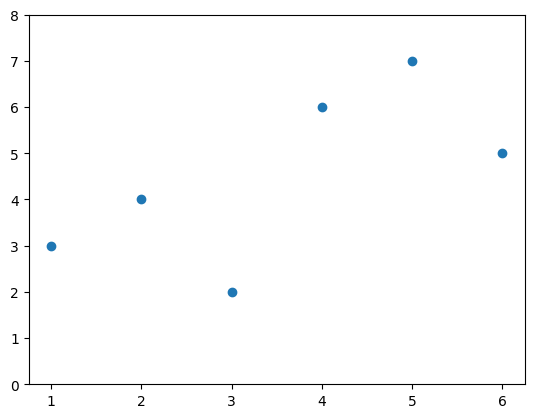

In [123]:
fig, ax = plt.subplots()
ax.plot(x, y, "o")
ax.set_ylim((0, 8))
plt.show()

In [156]:
import numbers


def _assemble_regression_matrix(X, breaks, degree=1):
    Acols = []
    bins = np.digitize(X, breaks).clip(None, len(breaks) - 1)
    for i, d in enumerate(degree):
        for k in range(d + 1):
            Acols.append(np.where(bins == i+1, X ** k, 0.))

    A = np.column_stack(Acols)
    return A


def _assemble_continuity_constraints(breaks, degree=1):
    m = len(degree) + sum(degree)
    Crows = []
    i = 0
    for b, (d0, d1) in zip(breaks[1:-1], itertools.pairwise(degree)):
        row = np.zeros(m)
        row[i:(i+d0+1)] = [b ** k for k in range(d0 + 1)]
        row[(i+d0+1):(i+d0+d1+2)] = [-1. * b ** k for k in range(d1 + 1)]
        Crows.append(row)
        i += d0 + 1

    C = np.row_stack(Crows)
    return C


def _lstsq_constrained(X, y, breaks, degree=1, continuity="c0", weights=None):
    breaks = np.sort(breaks)
    if isinstance(degree, numbers.Number):
        degree = [degree] * (len(breaks) - 1)

    A = _assemble_regression_matrix(X, breaks, degree)
    n, p = A.shape

    if weights is None:
        weights = np.ones(shape=n)

    Aw = A * weights.reshape(-1, 1)
    yw = y * weights

    if continuity is not None and len(breaks) > 2:
        C = _assemble_continuity_constraints(breaks, degree)
        r, _ = C.shape

        K = np.zeros((p + r, p + r))
        K[:p, :p] = np.dot(Aw.T, Aw)
        K[:p, p:] = C.T
        K[p:, :p] = C

        Z = np.zeros(p + r)
        Z[:p] = np.dot(Aw.T, yw)

        beta = linalg.solve(K, Z)
        coef = beta[:p]

        e = np.dot(A, coef) - y
        ssr = np.dot(e, e)
    else:
        coef, ssr, _, _ = linalg.lstsq(Aw, yw)

    return coef, ssr

In [157]:
y

array([3., 4., 2., 6., 7., 5.])

In [158]:
coefs = _lstsq_constrained(x, y, [1., 3.5, 6.], degree=[0, 1], weights=weights, continuity="c0")

In [159]:
coefs

(array([3.9998886 , 0.79968808, 0.91434301]), 11.685466071597638)

In [160]:
coefs = _lstsq_constrained(x, y, [1., 3.5, 6.], degree=[0, 1], weights=weights, continuity=None)

In [161]:
coefs

(array([ 3.99970006,  8.5       , -0.5       ]), 6.499100179963999)

In [137]:
xx = np.linspace(1, 6, 1000)
AA = _assemble_regression_matrix(xx, [1., 3.5, 6.], degree=[0, 1])
yy = np.dot(AA, coefs)

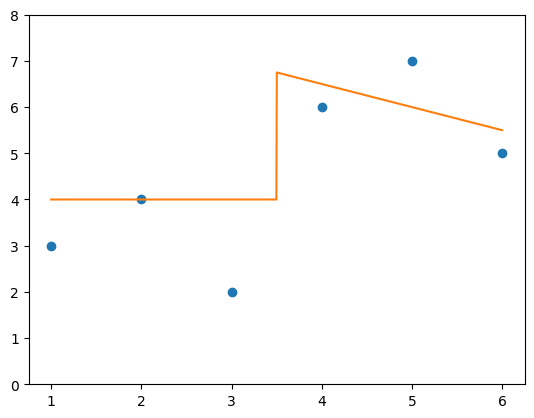

In [138]:
fig, ax = plt.subplots()
ax.plot(x, y, "o")
ax.plot(xx, yy, "-")
ax.set_ylim((0, 8))
plt.show()